# 2. Potential sites of chemical modification

An initial scan of the antibody sequences is presented based purely upon sequence. If a
structural analysis was also requested, this section should be used in conjunction with the
molecular surface analysis described in a subsequent section. Any of the sites listed below
could be candidates for further consideration if the molecular surface analysis shows that they
are significantly exposed on the surface of the antibody, increasing their propensity for chemical
modification. The canonical sequence analysis is also helpful here, since each of these sites
can also be considered in the context of their frequency of occurrence within the canonical
library of homologous sequences.

## tryptophan and methionine residues in CDRs

The indole ring of Tryptophan (W) is prone to oxidation, especially when exposed to UV.
Tryptophan residues in exposed positions in the CDRs, can affect the solubility of an antibody
and lead to non-specific antigen binding.
Methionine (M) residues are prone to oxidation through the formation of a sulfoxide, and can
also become irreversibly oxidized. This oxidation can be accelerated by exposure to metal ions
(e.g. from the wall of a stainless steel fermentation vessel).


## potential deamidation positions

Asparagine (N) and glutamine (Q) residues are particularly prone to deamidation when they are
followed in the sequence by amino acids with smaller side chains, that leave the intervening
peptide group more exposed. Deamidation proceeds much more quickly if the susceptible
amino acid is followed by a small, flexible residue such as glycine whose low steric hindrance
leaves the peptide group open for attack.


Search patterns: ASN/GLN-ALA/GLY/SER/THR

## potential o-linked glycosylation sites

The O-linked glycosylation of serine and threonine residues seems to be particularly sensitive to
the presence of one or more proline residues in their vicinity in the sequence, particularly in the2
-1 and +3 positions.


Search patterns: PRO-SER/THR, SER/THR-X-X-PRO

## potential n-linked glycosylation sites
Search patterns: ASN-X-SER/THR

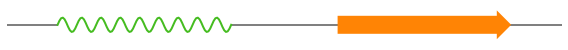

In [8]:
# Code source: Patrick Kunzmann
# License: BSD 3 clause

from tempfile import gettempdir
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
import biotite
import biotite.structure as struc
import biotite.structure.io.mmtf as mmtf
import biotite.sequence as seq
import biotite.sequence.graphics as graphics
import biotite.sequence.io.genbank as gb
import biotite.database.rcsb as rcsb
import biotite.database.entrez as entrez
import biotite.application.dssp as dssp


# Create 'FeaturePlotter' subclasses
# for drawing the scondary structure features

class HelixPlotter(graphics.FeaturePlotter):

    def __init__(self):
        pass

    # Check whether this class is applicable for drawing a feature
    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "helix":
                    return True
        return False

    # The drawing function itself
    def draw(self, axes, feature, bbox, loc, style_param):
        # Approx. 1 turn per 3.6 residues to resemble natural helix
        n_turns = np.ceil((loc.last - loc.first + 1) / 3.6)
        x_val = np.linspace(0, n_turns * 2*np.pi, 100)
        # Curve ranges from 0.3 to 0.7
        y_val = (-0.4*np.sin(x_val) + 1) / 2

        # Transform values for correct location in feature map
        x_val *= bbox.width / (n_turns * 2*np.pi)
        x_val += bbox.x0
        y_val *= bbox.height
        y_val += bbox.y0

        # Draw white background to overlay the guiding line
        background = Rectangle(
            bbox.p0, bbox.width, bbox.height, color="white", linewidth=0
        )
        axes.add_patch(background)
        axes.plot(
            x_val, y_val, linewidth=2, color=biotite.colors["dimgreen"]
        )


class SheetPlotter(graphics.FeaturePlotter):

    def __init__(self, head_width=0.8, tail_width=0.5):
        self._head_width = head_width
        self._tail_width = tail_width


    def matches(self, feature):
        if feature.key == "SecStr":
            if "sec_str_type" in feature.qual:
                if feature.qual["sec_str_type"] == "sheet":
                    return True
        return False

    def draw(self, axes, feature, bbox, loc, style_param):
        x = bbox.x0
        y = bbox.y0 + bbox.height/2
        dx = bbox.width
        dy = 0

        if  loc.defect & seq.Location.Defect.MISS_RIGHT:
            # If the feature extends into the prevoius or next line
            # do not draw an arrow head
            draw_head = False
        else:
            draw_head = True

        axes.add_patch(biotite.AdaptiveFancyArrow(
            x, y, dx, dy,
            self._tail_width*bbox.height, self._head_width*bbox.height,
            # Create head with 90 degrees tip
            # -> head width/length ratio = 1/2
            head_ratio=0.5, draw_head=draw_head,
            color=biotite.colors["orange"], linewidth=0
        ))


# Test our drawing functions with example annotation
annotation = seq.Annotation([
    seq.Feature("SecStr", [seq.Location(10, 40)], {"sec_str_type" : "helix"}),
    seq.Feature("SecStr", [seq.Location(60, 90)], {"sec_str_type" : "sheet"}),
])

fig = plt.figure(figsize=(8.0, 0.8))
ax = fig.add_subplot(111)
graphics.plot_feature_map(
    ax, annotation, multi_line=False, loc_range=(1,100),
    # Register our drawing functions
    feature_plotters=[HelixPlotter(), SheetPlotter()]
)
fig.tight_layout()

In [3]:
from Bio import SeqIO

record = SeqIO.read("../data/sequence.fasta", "fasta")
print(record)

ID: Aflibercept
Name: Aflibercept
Description: Aflibercept
Number of features: 0
Seq('SDTGRPFVEMYSEIPEIIHMTEGRELVIPCRVTSPNITVTLKKFPLDTLIPDGK...SPG')


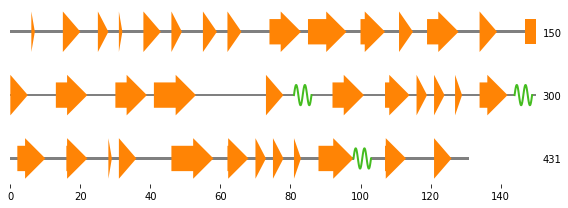

In [18]:
import biotite.structure as struc
import biotite.structure.io.pdb as pdb
import biotite.sequence as seq

# Dictionary to convert 'secStructList' codes to DSSP values
# https://github.com/rcsb/mmtf/blob/master/spec.md#secstructlist
sec_struct_codes = {0 : "I",
                    1 : "S",
                    2 : "H",
                    3 : "E",
                    4 : "G",
                    5 : "B",
                    6 : "T",
                    7 : "C"}
# Converter for the DSSP secondary structure elements
# to the classical ones
dssp_to_abc = {"I" : "c",
               "S" : "c",
               "H" : "a",
               "E" : "b",
               "G" : "c",
               "B" : "b",
               "T" : "c",
               "C" : "c"}


# Helper function to convert secondary structure array to annotation
# and visualize it
def visualize_secondary_structure(sse, first_id):

    def _add_sec_str(annotation, first, last, str_type):
        if str_type == "a":
            str_type = "helix"
        elif str_type == "b":
            str_type = "sheet"
        else:
            # coil
            return
        feature = seq.Feature(
            "SecStr", [seq.Location(first, last)], {"sec_str_type" : str_type}
        )
        annotation.add_feature(feature)

    # Find the intervals for each secondary structure element
    # and add to annotation
    annotation = seq.Annotation()
    curr_sse = None
    curr_start = None
    for i in range(len(sse)):
        if curr_start is None:
            curr_start = i
            curr_sse = sse[i]
        else:
            if sse[i] != sse[i-1]:
                _add_sec_str(
                    annotation, curr_start+first_id, i-1+first_id, curr_sse
                )
                curr_start = i
                curr_sse = sse[i]
    # Add last secondary structure element to annotation
    _add_sec_str(annotation, curr_start+first_id, i-1+first_id, curr_sse)

    fig = plt.figure(figsize=(8.0, 3.0))
    ax = fig.add_subplot(111)
    graphics.plot_feature_map(
        ax, annotation, symbols_per_line=150,
        loc_range=(first_id, first_id+len(sse)),
        show_numbers=True, show_line_position=True,
        feature_plotters=[HelixPlotter(), SheetPlotter()]
    )
    fig.tight_layout()


# Fetch and load structure
# file_name = rcsb.fetch("1QGD", "mmtf", gettempdir())
file_name = rcsb.fetch("1QGD", "mmtf", gettempdir())

mmtf_file = mmtf.MMTFFile.read(file_name)
pdb_file = pdb.PDBFile.read("../data/predict_aflibercept.pdb")
# array = mmtf.get_structure(mmtf_file, model=1)
array = pdb_file.get_structure(model=1)
# Transketolase homodimer
tk_dimer = array[struc.filter_amino_acids(array)]
# Transketolase monomer
tk_mono = tk_dimer[tk_dimer.chain_id == "A"]

# The chain ID corresponding to each residue
# chain_id_per_res = array.chain_id[struc.get_residue_starts(tk_dimer)]

# Visualize seconday structure array
# Sine the residues may not start at 1,
# provide the actual first residue ID

sse = dssp.DsspApp.annotate_sse(tk_mono)
sse = np.array([dssp_to_abc[e] for e in sse], dtype="U1")
visualize_secondary_structure(sse, tk_mono.res_id[0])
